In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import numpy as np
import pandas as pd
import scipy

In [1]:
##just function for plotting, nevermind

def moving_average(data, n):
    return np.average(data[:n])

def plotMovingAverage(data, n, label):

    """
    data - dataframe with timedata
    n - rolling window size

    """
    rolling_mean = []
    tiker = []
    for k in range(n, len(data), n):
        rol_mean = moving_average(data[k:], k)
        rolling_mean.append(rol_mean)
        tiker.append(k)

    plt.figure(figsize=(15,5))
    plt.title(label)
    plt.plot(data, label="Actual values")
    plt.plot(tiker, rolling_mean, 'g', label="Rolling mean trend: n=" + str(n), linewidth=3, color='red')
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.legend(loc="lower right")
    plt.grid(True)

### $\varepsilon$-Greedy Policy:
$$
\begin{array}{l}
\pi(a|s) =
\left\{
\begin{array}{ll}
1 - \varepsilon + \varepsilon / m,& \text{ если } a \in \mathrm{argmax}_{a' \in \mathcal{A}}\, Q(s,a'),\\
\varepsilon / m,& \text{ иначе }
\end{array}
\right.
\end{array}
$$

In [3]:
import numpy as np

def get_epsilon_greedy_action(q_values, epsilon, action_n):
    argmax_action = np.argmax(q_values)
    probs = epsilon * np.ones(action_n) / action_n
    probs[argmax_action] += 1 - epsilon
    action = np.random.choice(np.arange(action_n), p=probs)
    return action

### Monte-Carlo Algorithm

Let's $Q(s,a) = 0$, $N(s,a) = 0$ and $\varepsilon = 1$.

For each episode $k \in \overline{1,K}$ we do:

1. Because of $\pi = \varepsilon\text{-greedy}(Q)$ we get trajectories $\tau = (S_0,A_0,\ldots,S_T)$ and rewards $(R_0,\ldots,R_{T-1})$. Then we can determine $(G_0,\ldots,G_{T-1}):$
   
$$
G_t = \sum\limits_{k=t}^{T-1} \gamma^{k-t} R_t,\quad G_{T-1} = R_{T-1},\quad G_{T-2} = R_{T-2} + \gamma R_{T-1},\quad G_i = R_i + \gamma G_{i+1},\quad G_{T} = Q(S_T,\pi_{greedy}(S_T)).
$$

3. For each $t \in \overline{0,T-1}$ we improve $Q$ и $N$:

$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \frac{1}{N(S_t,A_t) + 1}\big(G_t - Q(S_t,A_t)\big),
$$

$$
N(S_t,A_t) \leftarrow N(S_t,A_t) + 1
$$

Reduce $\varepsilon$ by law that we want (it's sometimes better to use soft decreasing law in epsilon, f.e. tanh or sigmoid with boundaries between 1 and 0).

In [4]:
def MonteCarlo(env, episode_n, trajectory_len=500, gamma=0.99):
    total_rewards = []

    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))
    counter = np.zeros((state_n, action_n))

    for episode in range(episode_n):
        epsilon = 1 - episode / episode_n
        trajectory = {'states': [], 'actions': [], 'rewards': []}

        state = env.reset()
        for _ in range(trajectory_len):
            trajectory['states'].append(state)

            action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
            trajectory['actions'].append(action)

            state, reward, done, _ = env.step(action)
            trajectory['rewards'].append(reward)

            if done:
                break
        total_rewards.append(sum(trajectory['rewards']))

        real_trajectory_len = len(trajectory['rewards'])
        returns = np.zeros(real_trajectory_len + 1)
        for t in range(real_trajectory_len - 1, -1, -1):
            returns[t] = trajectory['rewards'][t] + gamma * returns[t + 1]

        for t in range(real_trajectory_len):
            state = trajectory['states'][t]
            action = trajectory['actions'][t]
            qfunction[state][action] += (returns[t] - qfunction[state][action]) / (1 + counter[state][action])
            counter[state][action] += 1

    return total_rewards


### Solving Taxi-v3 by means of MonteCarlo

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-1-7c43b3e35d43>:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(tiker, rolling_mean, 'g', label="Rolling mean trend: n=" + str(n), linewidth=3, color='red')


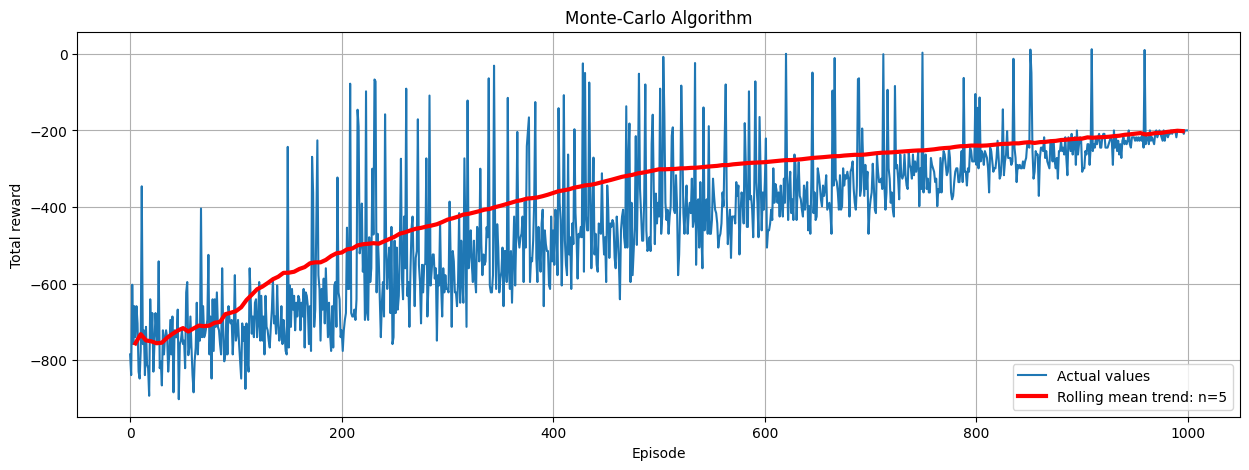

In [5]:
import gym
import matplotlib.pyplot as plt

env = gym.make("Taxi-v3")

total_rewards = MonteCarlo(env, episode_n=1000, trajectory_len=1000, gamma=0.8)

plotMovingAverage(total_rewards, 5, 'Monte-Carlo Algorithm')